In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu, fisher_exact

In [ ]:
# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")

In [3]:
# Load the data
df = pd.read_csv('results_with_recall.csv', sep=';')
# EXCLUDE PARTICIPANT 1
df = df[df['participant_id'] != 1].copy()

In [30]:
# Create condition column
df['condition'] = df['modality'].apply(lambda x: 'Traditional' if 'TRADITIONAL' in x else 'AR')

print(f"Number of participants: {df['participant_id'].nunique()}")
print(f"Total observations: {len(df)}\n")

Number of participants: 10
Total observations: 60



In [31]:
# Overall recall by condition
condition_summary = df.groupby('condition')['recall_binary'].agg([
    ('n_words', 'count'),
    ('n_correct', 'sum'),
    ('recall_rate', 'mean'),
    ('std', 'std')
]).round(3)

print(condition_summary)

             n_words  n_correct  recall_rate    std
condition                                          
AR                30         23        0.767  0.430
Traditional       30          9        0.300  0.466


In [32]:
# Calculate recall rate per participant per condition
participant_scores = df.groupby(['participant_id', 'condition'])['recall_binary'].mean().reset_index()
participant_scores.columns = ['participant_id', 'condition', 'recall_rate']

# Pivot to wide format
scores_wide = participant_scores.pivot(index='participant_id', columns='condition', values='recall_rate')

print("\nParticipant scores by condition:")
print(scores_wide)


Participant scores by condition:
condition             AR  Traditional
participant_id                       
2               0.666667     0.333333
3               1.000000     0.666667
4               0.666667     0.333333
5               0.666667     0.000000
6               1.000000     0.333333
7               0.666667     0.333333
8               0.666667     0.333333
9               0.666667     0.333333
10              0.666667     0.333333
11              1.000000     0.000000


In [33]:
# Wilcoxon test (paired)
traditional_scores = scores_wide['Traditional'].values
ar_scores = scores_wide['AR'].values

stat, p_value = wilcoxon(traditional_scores, ar_scores)

print(f"\nWilcoxon Signed-Rank Test:")
print(f"Statistic: {stat:.3f}")
print(f"p-value: {p_value:.4f}")
print(f"Significant: {'Yes (p < .05)' if p_value < 0.05 else 'No (p >= .05)'}")

print(f"\nTraditional: Median={np.median(traditional_scores):.3f}, Mean={np.mean(traditional_scores):.3f}")
print(f"AR:          Median={np.median(ar_scores):.3f}, Mean={np.mean(ar_scores):.3f}")


Wilcoxon Signed-Rank Test:
Statistic: 0.000
p-value: 0.0020
Significant: Yes (p < .05)

Traditional: Median=0.333, Mean=0.300
AR:          Median=0.667, Mean=0.767


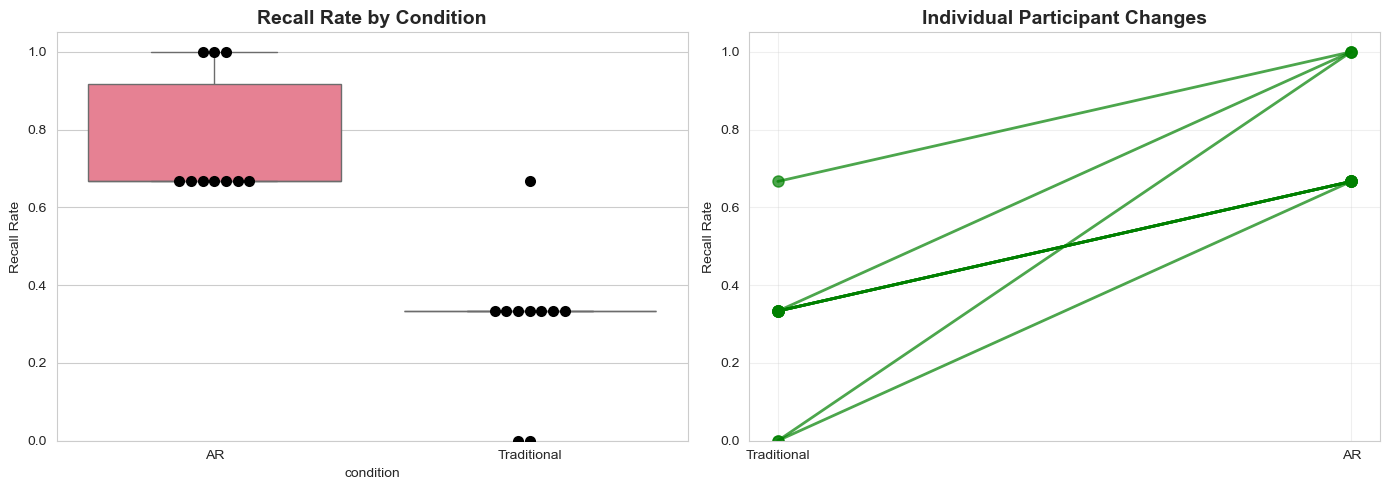

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
sns.boxplot(data=participant_scores, x='condition', y='recall_rate', ax=axes[0])
sns.swarmplot(data=participant_scores, x='condition', y='recall_rate', color='black', size=8, ax=axes[0])
axes[0].set_title('Recall Rate by Condition', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Recall Rate')
axes[0].set_ylim(0, 1.05)

# Paired lines
for idx, row in scores_wide.iterrows():
    color = 'green' if row['AR'] > row['Traditional'] else 'red'
    axes[1].plot(['Traditional', 'AR'], [row['Traditional'], row['AR']], 
                 'o-', color=color, alpha=0.7, linewidth=2, markersize=8)
axes[1].set_title('Individual Participant Changes', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Recall Rate')
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_by_condition.png', dpi=300, bbox_inches='tight')
plt.show()


Recall rate by word:
castravete      (Traditional ): 0.00% (0/10)
cupă            (AR          ): 60.00% (6/10)
jachetă         (Traditional ): 80.00% (8/10)
lingură         (Traditional ): 10.00% (1/10)
măr             (AR          ): 80.00% (8/10)
pantofi         (AR          ): 90.00% (9/10)

Overall performance:
Traditional words: 30.00%
AR words: 76.67%


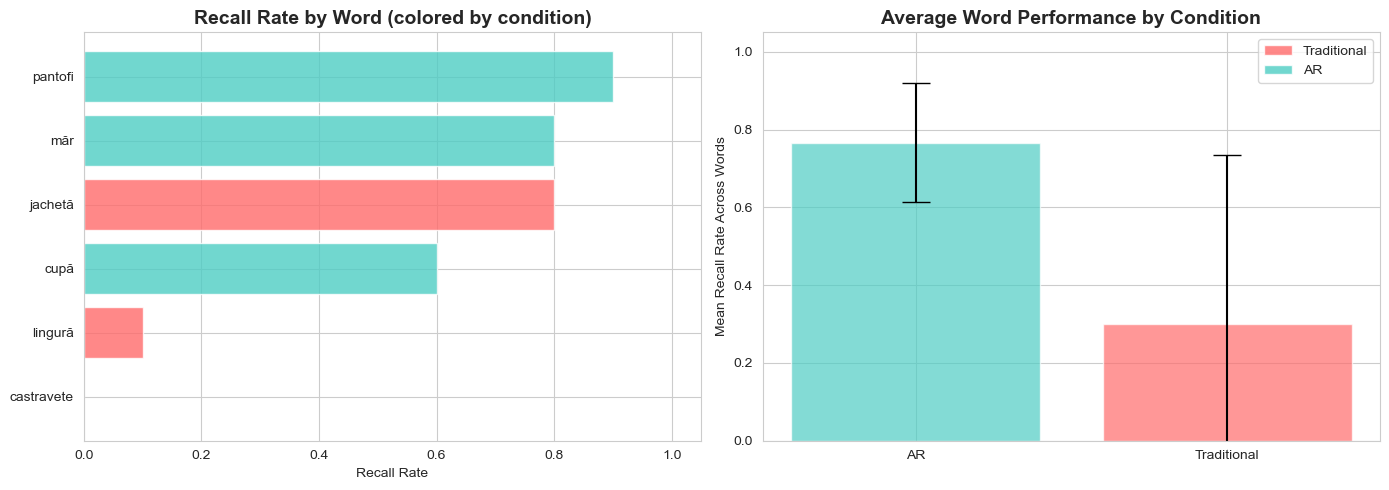

In [41]:
# Word-level recall rates
word_summary = df.groupby(['target_word', 'condition'])['recall_binary'].agg([
    'count', 'sum', 'mean'
]).reset_index()
word_summary.columns = ['target_word', 'condition', 'n', 'n_correct', 'recall_rate']

print("\nRecall rate by word:")
for _, row in word_summary.iterrows():
    print(f"{row['target_word']:15} ({row['condition']:12}): {row['recall_rate']:.2%} ({int(row['n_correct'])}/{int(row['n'])})")

# Instead, compare overall word difficulty by condition
print("\nOverall performance:")
print(f"Traditional words: {df[df['condition']=='Traditional']['recall_binary'].mean():.2%}")
print(f"AR words: {df[df['condition']=='AR']['recall_binary'].mean():.2%}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart by word (colored by condition)
word_summary_sorted = word_summary.sort_values('recall_rate')
colors = ['#FF6B6B' if c == 'Traditional' else '#4ECDC4' for c in word_summary_sorted['condition']]

axes[0].barh(range(len(word_summary_sorted)), word_summary_sorted['recall_rate'], color=colors, alpha=0.8)
axes[0].set_yticks(range(len(word_summary_sorted)))
axes[0].set_yticklabels(word_summary_sorted['target_word'])
axes[0].set_xlabel('Recall Rate')
axes[0].set_title('Recall Rate by Word (colored by condition)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1.05)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.8, label='Traditional'),
                   Patch(facecolor='#4ECDC4', alpha=0.8, label='AR')]
axes[1].legend(handles=legend_elements)

# Grouped by condition
condition_word_means = word_summary.groupby('condition')['recall_rate'].agg(['mean', 'std', 'count'])
axes[1].bar(condition_word_means.index, condition_word_means['mean'], 
           yerr=condition_word_means['std'], capsize=10, alpha=0.7, color=['#4ECDC4', '#FF6B6B'])
axes[1].set_ylabel('Mean Recall Rate Across Words')
axes[1].set_title('Average Word Performance by Condition', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('analysis_by_word.png', dpi=300, bbox_inches='tight')
plt.show()


Participant scores by nationality:

Egyptian:
  P5: 0.333

Indian:
  P2: 0.500

Italian:
  P3: 0.833
  P7: 0.500
  P8: 0.500
  P11: 0.500

Serbian:
  P4: 0.500

Spanish:
  P6: 0.667

Swedish:
  P9: 0.500

Turkish:
  P10: 0.500


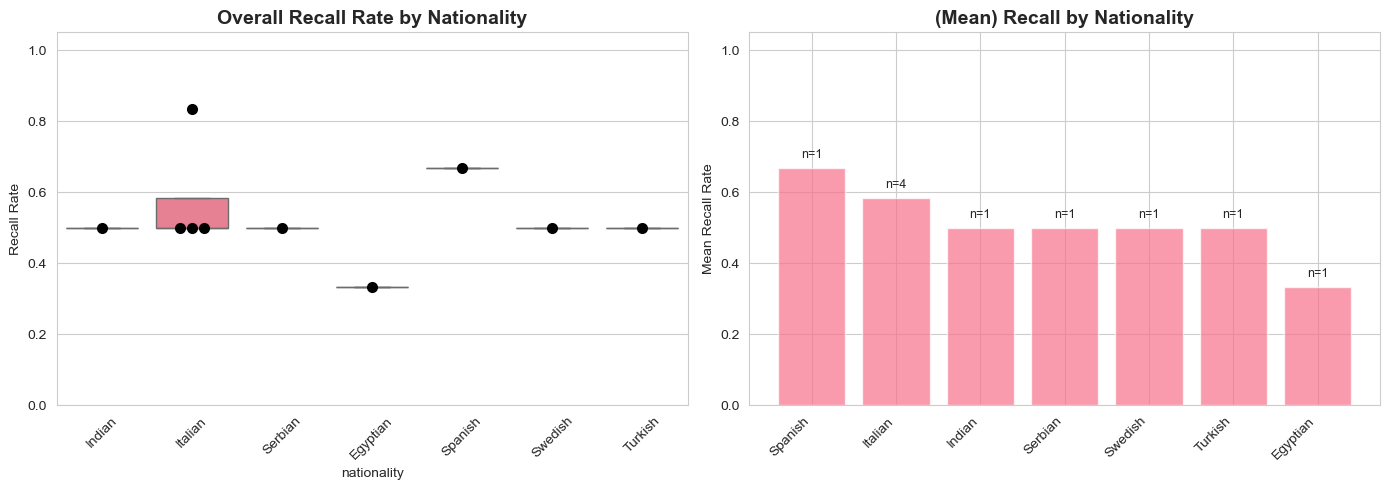

In [44]:
# Overall recall by participant and nationality
nationality_scores = df.groupby(['participant_id', 'nationality'])['recall_binary'].mean().reset_index()
nationality_scores.columns = ['participant_id', 'nationality', 'recall_rate']

print("\nParticipant scores by nationality:")
for nat in sorted(nationality_scores['nationality'].unique()):
    nat_data = nationality_scores[nationality_scores['nationality'] == nat]
    print(f"\n{nat}:")
    for _, row in nat_data.iterrows():
        print(f"  P{int(row['participant_id'])}: {row['recall_rate']:.3f}")


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot by nationality
sns.boxplot(data=nationality_scores, x='nationality', y='recall_rate', ax=axes[0])
sns.swarmplot(data=nationality_scores, x='nationality', y='recall_rate', 
              color='black', size=8, ax=axes[0])
axes[0].set_title('Overall Recall Rate by Nationality', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Recall Rate')
axes[0].set_ylim(0, 1.05)
axes[0].tick_params(axis='x', rotation=45)

# Mean by nationality with counts
nat_means = nationality_scores.groupby('nationality').agg({
    'recall_rate': ['mean', 'count']
}).reset_index()
nat_means.columns = ['nationality', 'mean', 'count']
nat_means = nat_means.sort_values('mean', ascending=False)

bars = axes[1].bar(range(len(nat_means)), nat_means['mean'], alpha=0.7)
axes[1].set_xticks(range(len(nat_means)))
axes[1].set_xticklabels(nat_means['nationality'], rotation=45, ha='right')
axes[1].set_ylabel('Mean Recall Rate')
axes[1].set_title('(Mean) Recall by Nationality', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.05)

# Add n labels on bars
for i, (bar, count) in enumerate(zip(bars, nat_means['count'])):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'n={int(count)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('analysis_by_nationality.png', dpi=300, bbox_inches='tight')
plt.show()